# Проверка гипотез по увеличению выручки в интернет-магазине — оценить результаты A/B теста

**Описание исследования.**

В крупном интернет-магазине мной вместе с отделом маркетинга подготовлен список гипотез для увеличения выручки
_____
**Цель исследования.**

Провести анализ гипотез, которые приведут к увеличению выручки

_____
**Задачи исследования.**
* Приоритизировать подготовленные гипотезы
* Запустить A/B тест и проанализировать результаты
_____
**Исходные данные.**
    
Файл /datasets/hypothesis.csv - гипотезы
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv - заказы
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv - посетители
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

______

**Данное исследование разделим на несколько частей:**

* [Изучение общей информации](#section_1)
* [Подготовка данных](#section_2)
* [Приоритизация гипотез](#section_3)
* [Анализ A/B-теста](#section_4)

<a id='section_1'></a>
## Изучение общей информации

**В этом шаге:**
* подключим библиотеки
* откроем и изучим файлы, необходимые для работы

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)
from scipy import stats
import numpy as np
from datetime import datetime, timedelta

pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_colwidth', 0)

In [4]:
data = pd.read_csv('datasets/hypothesis.csv') # гипотезы
visitors = pd.read_csv('datasets/visitors.csv') # посетители
orders = pd.read_csv('datasets/orders.csv') # покупки

data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
print('Таблица orders\n')
orders.info()

orders.head()

Таблица orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [4]:
print('Таблица visitors\n')
visitors.info()
visitors.head()

Таблица visitors

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<a id='section_2'></a>
## Подготовка данных

**В этом шаге**
* Приведем данные к нужным типам, переименуем столбцы
* Проверим и справим дубликаты, приопуски в данных

Приведем даты к нужным типам, переименуем столбцы для более удобной работы с имеющимися методами 

In [5]:
data.columns = data.columns.str.lower()
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])
orders.rename(columns={'transactionId': 'orderId', 'visitorId' : 'userId'}, inplace=True)

Проверим дубликаты в таблицах

In [6]:
print('Дубликатов в таблице "orders":', orders.duplicated().sum())
print('Дубликатов в таблице "visitors":', visitors.duplicated().sum())

Дубликатов в таблице "orders": 0
Дубликатов в таблице "visitors": 0


Проверим пропуски в таблицах

In [30]:
print('Пропуски в таблице "orders":\n', orders.isna().sum())
print('\nПропуски в таблице "visitors":\n', visitors.isna().sum())

Пропуски в таблице "orders":
 orderId    0
userId     0
date       0
revenue    0
group      0
dtype: int64

Пропуски в таблице "visitors":
 date        0
group       0
visitors    0
dtype: int64


<a id='section_3'></a>
## Приоритизация гипотез

**В этом шаге:**
* Посчитаем ICE для гипотез
* Посчитаем RICE для гипотез
* Отсортируем гипотезы по среднему рангу из обоих методов

### Посчитаем ICE для гипотез

In [8]:
data['ice'] = (data['impact'] * data['confidence']) /  data['efforts']

print('Приоритет гипотез по методу ICE')
data[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

Приоритет гипотез по методу ICE


,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


***Вывод:*** Самые перспективные гипотезы по методу ICE получились: 8,0,7,6,2

### Посчитаем RICE для гипотез

In [9]:
data['rice'] = (data['reach'] * data['impact'] * data['confidence']) / data['efforts']

print('Приоритет гипотез по методу RICE')
data[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

Приоритет гипотез по методу RICE


,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


***Вывод:*** Самые перспективные гипотезы по методу RICE получились: 7,2,0,6,8. Приоритезация изменилась, так как стала учитываться еще и оценка количества затрагиваемых пользователей

В обоих методах в пятерке лидеров оказались гипотезы 8,0,7,6,2 хоть и в разном порядке. Можно для наглядности рейтинга отсортировать гипотезы по среднему рангу из обоих методов

### Отсортируем гипотезы по среднему рангу из обоих методов

In [10]:
data['ice_rank'] = data['ice'].rank(ascending=False)
data['rice_rank'] = data['rice'].rank(ascending=False)
data['mean_rank'] = (data['ice_rank'] + data['rice_rank']) / 2

print('Гипотезы, отсортированные по среднему рангу из обоих методов')
data[['hypothesis', 'mean_rank']].sort_values(by='mean_rank')

Гипотезы, отсортированные по среднему рангу из обоих методов


,hypothesis,mean_rank
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",2.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",2.75
8,"Запустить акцию, дающую скидку на товар в день рождения",3.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",3.50
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",3.75
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",6.75
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",7.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",7.25
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",9.00


***Вывод:*** Из двух методов порядок приоритов гипотез такой: 7,0,8,2,6

***Вывод по шагу:*** С помощью двух методов (ICE и RICE) удалось увидеть как распределяются приоритеты гипотез в зависимости от метода их оценки. Также определили, что гипотезы 7,0,8,2,6 наиболее приоритетны исходя из обоих методов.

<a id='section_4'></a>
## Анализ A/B-теста

**В этом шаге:**
* Построим график кумулятивной выручки по группам
* Построим график кумулятивного среднего чека по группам по дням
* Построим график относительного изменения кумулятивного среднего чека группы B к группе A
* Построим график кумулятивной конверсии по группам
* Построим график относительного изменения кумулятивной конверсии группы B к группе A
* Построим точечный график количества заказов по пользователям
* Посчитаем 95-й и 99-й перцентили количества заказов на пользователя
* Построим точечный график стоимостей заказов
* Посчитаем 95-й и 99-й перцентили стоимости заказов
* Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным
* Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным
* Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.
* Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным
* Примем решение по результатам тестов

### Построим график кумулятивной выручки по группам

График кумулятивной выручки по группам


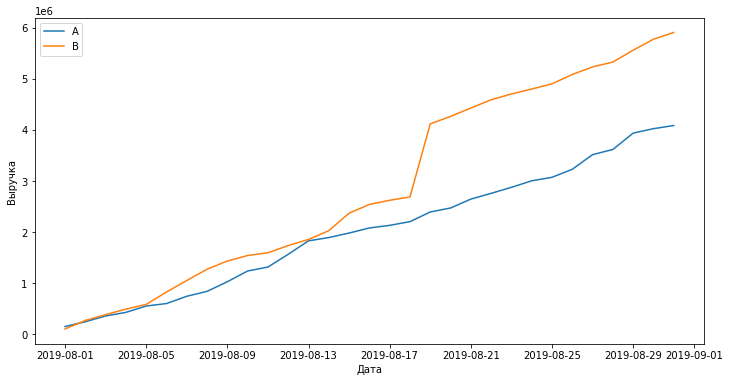

In [11]:


print('График кумулятивной выручки по группам')

# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

ordersAggregated = datesGroups\
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'orderId' : 'nunique', 'userId' : 'nunique', 'revenue' : 'sum'}), axis=1)\
    .sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.columns = ['date','group','orders','buyers','revenue','visitors']

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12,6))

# Строим график выручки группы А
plt.plot( cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A' )

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xlabel('Дата')
plt.ylabel('Выручка')

plt.legend();


***Вывод:*** До середины сегмент B имеет совсем небольшое лидерство, но в какой-то момент произошел резкий скачек и отрыв сохранился до самого конца графика. Похоже что на скачек повлияли аномальные данные.

### Построим график кумулятивного среднего чека по группам по дням

График кумулятивного среднего чека по группам


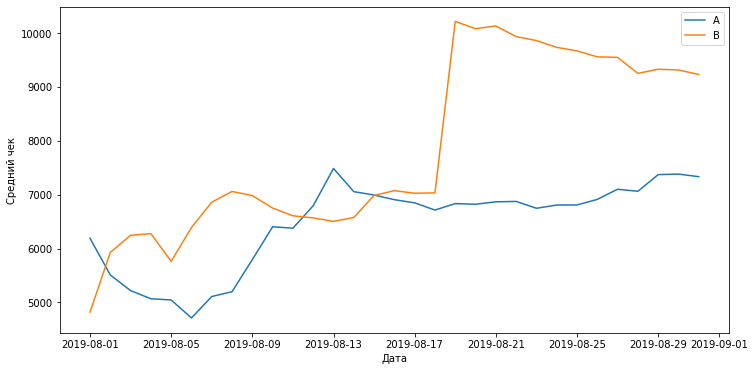

In [12]:
print('График кумулятивного среднего чека по группам')

plt.figure(figsize=(12,6))

cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend();

***Вывод:*** Оба графика кумулятивного среднего чека по группам имеют колебания и периодически пересекаются,однако опять видим резкий скачек графика B после чего он сильно вырвался вверх. Похоже и тут аномальные значения сильно искажают картину.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

График относительного изменения кумулятивного среднего чека группы B к группе A


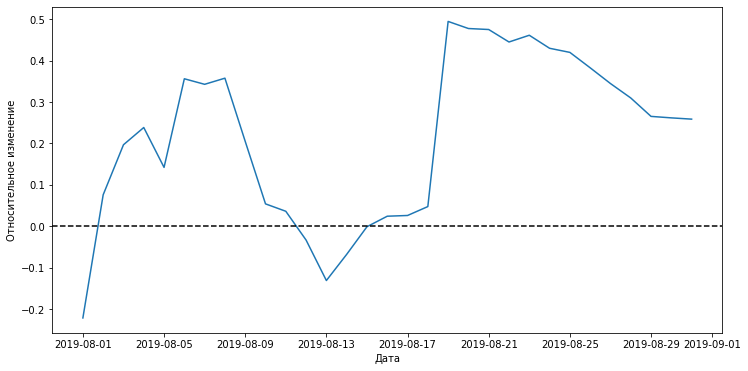

In [13]:
print('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.figure(figsize=(12,6))


# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,\
        left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'],(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--'); 

plt.xlabel('Дата')
plt.ylabel('Относительное изменение');

***Вывод:*** Видно, что неоднократно были резкие скачки, которые вероятно опять же возникли из-за анамальных выбросов.

### Построим график кумулятивной конверсии по группам

График кумулятивной конверсии по группам


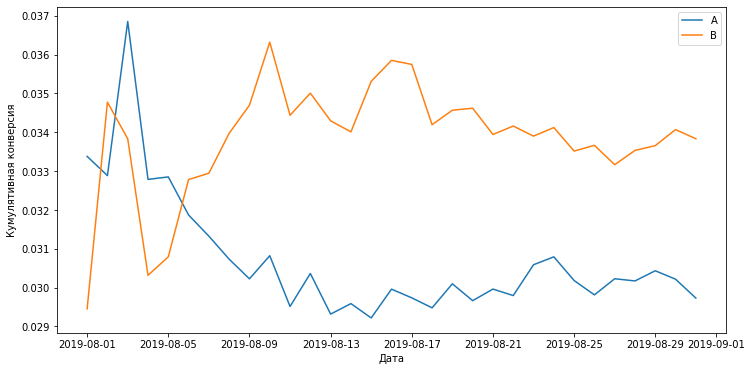

In [14]:
print('График кумулятивной конверсии по группам')
plt.figure(figsize=(12,6))

# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B') 

plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.legend();

***Вывод:*** В начале были сильные колебания и каждый график периодически оказывался сверху. Однако в определенный момент оба графика зафиксировались каждый на своей отметке. При этом график 'B' занял верхнюю позицию относительно 'A' и его установившаяся отметка примерно на 10% выше.

### Построим график относительного изменения кумулятивной конверсии группы B к группе A

График относительного изменения кумулятивной конверсии группы B к группе A


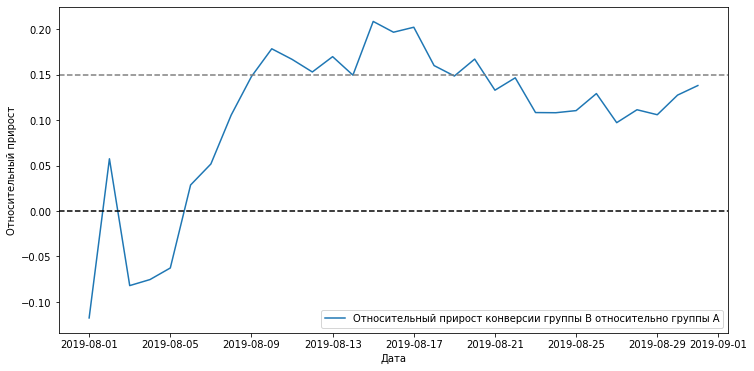

In [15]:
print('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.figure(figsize=(12,6))

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']],\
         left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'],\
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,\
         label="Относительный прирост конверсии группы B относительно группы A")

plt.xlabel('Дата')
plt.ylabel('Относительный прирост')
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--');

***Вывод:*** В самом начале нет очевидного лидерства, но вскоре группа 'B' вырывается вверх и начинает варьировать вокруг отметки в 15% относительно группы 'A'

### Построим точечный график количества заказов по пользователям

График количества заказов по пользователям


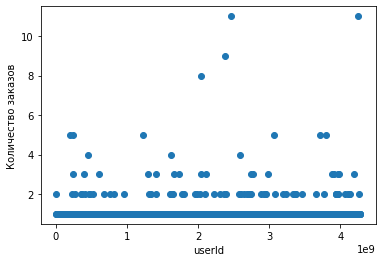

In [16]:
orders_counts=orders.groupby('userId', as_index=False).agg({'orderId': 'nunique', 'group' : 'first'})
orders_counts.rename(columns={'orderId': 'orders_count'}, inplace=True)

print('График количества заказов по пользователям')
plt.xlabel('userId')
plt.ylabel('Количество заказов')
plt.scatter(orders_counts['userId'], orders_counts['orders_count']);

***Вывод:*** Видно огромную плотность пользователей с 1 заказом, большую плотность с 2мя, а вот начиная от 3х плотность очень небольшая. Пользователей редко привлекает больше 2х раз делать заказ. Возможно пользователи не часто видят новые и актуальные для них товары, и довольны быстро удовлетворяют потребности - за 1-2 заказа. Либо им трудно ориентироваться в большом каталоге без понятных категорий и ,поэтому, также они не могут видеть актуальные для них товары или трудно находят нужные.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [17]:
print('95-й и 99-й перцентили количества заказов на пользователя:',\
      np.percentile(orders_counts['orders_count'], [95, 99]))

95-й и 99-й перцентили количества заказов на пользователя: [2. 4.]


Определим пользователей, сделавших больше 2х заказов как аномальных, так как таких не более 5%.

In [18]:
orders_limit = 2

### Построим точечный график стоимостей заказов

График стоимостей заказов


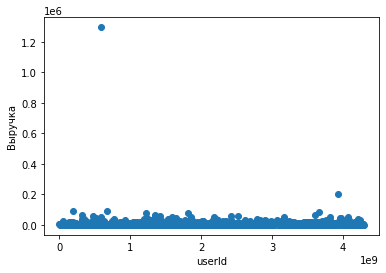

In [19]:
print('График стоимостей заказов')
plt.xlabel('userId')
plt.ylabel('Выручка')
plt.scatter(orders['orderId'], orders['revenue']);

Из-за двух явно выбивающихся значений график сложно рассмотреть, построим график без них

График стоимостей заказов < 200000


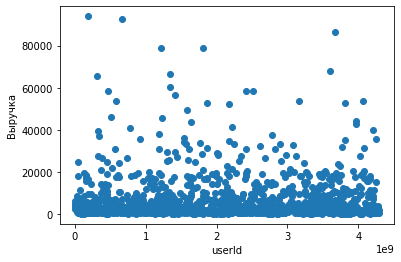

In [20]:
print('График стоимостей заказов < 200000')
orders_less200000 = orders.query('revenue < 200000')
plt.xlabel('userId')
plt.ylabel('Выручка')
plt.scatter(orders_less200000['orderId'], orders_less200000['revenue']);

***Вывод:*** Визуально плотность стоимостей заказов более менее равномерно уменьшается при увеличении рассматриваемой цены. Для большого интеренет магазина это нормально: очень много товаров на разную сумму и чем дороже сумма заказа, тем реже их делают. На какой-то отметке выше 20 000 график становится очень разреженным, таких заказов не так много, можно считать такие заказы аномальными. Точную границу определим далее.

### Посчитаем 95-й и 99-й перцентили стоимости заказов

In [21]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Выберем границу аномальных заказов больше 28000

In [22]:
too_expensive_price = 28000

***Вывод:*** Граница цены аномальных заказов выбрана

### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

Сначала подготовим данные

In [23]:

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)


ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']


In [24]:
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Названия столбцов полученных данных:

    date — дата;
    ordersPerDateA — количество заказов в выбранную дату в группе A;
    revenuePerDateA — суммарная выручка в выбранную дату в группе A;
    ordersPerDateB — количество заказов в выбранную дату в группе B;
    revenuePerDateB — суммарная выручка в выбранную дату в группе B;
    ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
    revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
    ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
    revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
    visitorsPerDateA — количество пользователей в выбранную дату в группе A;
    visitorsPerDateB — количество пользователей в выбранную дату в группе B;
    visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
    visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

In [25]:
# функция считает статистическую значимость различий в конверсии между группами 
# с отсеиванием аномальных пользователей (abnormalUsers)
def stat_conversion_between_groups(abnormalUsers):
    sampleAFiltered = pd.concat(
        [
            ordersByUsersA[
                np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
            ]['orders'],
            pd.Series(
                0,
                index=np.arange(
                    data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
                ),
                name='orders',
            ),
        ],
        axis=0,
    )

    sampleBFiltered = pd.concat(
        [
            ordersByUsersB[
                np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
            ]['orders'],
            pd.Series(
                0,
                index=np.arange(
                    data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
                ),
                name='orders',
            ),
        ],
        axis=0,
    )
    
    print('p-value =', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
    print('Относительный прирост конверсии в группе B:', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Сформулируем гипотезы:
* **Нулевая гипотеза**: Конверсии в группах А и В одинаковые
* **Альтернативная гипотеза**: Конверсии в группах А и В отличаются

In [26]:
# чтобы получить результат по сырым данным передадим в нашу функцию пустой список аномальных пользователей
display('Статистическая значимость различий в конверсии между группами по «сырым» данным:')
stat_conversion_between_groups([])

'Статистическая значимость различий в конверсии между группами по «сырым» данным:'

p-value = 0.017
Относительный прирост конверсии в группе B: 0.138


***Вывод:*** **Склоняемся к альтернативной гипотезе: конверсии в группах А и В отличаются**, так как p-value меньше 0,05 и относительный прирост конверсии в группе 'B' более 13%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы:
* **Нулевая гипотеза**: средний чек заказов у групп А и В одинаковый
* **Альтернативная гипотеза**: средний чек заказов у групп А и В различается

In [27]:
display('Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным:')

print('p-value =','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],\
                                          orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие среднего чека между сегментами', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

'Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным:'

p-value = 0.729
Относительное различие среднего чека между сегментами 0.259


***Вывод:*** P-value больше 0.05 — статистически значимых отличий в среднем чеке между группами нет, **нулевую гипотезу не отвергаем**. А вот относительное различие среднего чека между сегментами целых 25,9%. Похоже выбросы очень сильно влияют на результат.

### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. Для этого определим аномальных пользователей и передадим их в нашу функцию.

Гипотезы:
* **Нулевая гипотеза**: Конверсии в группах А и В одинаковые
* **Альтернативная гипотеза**: Конверсии в группах А и В отличаются

In [28]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > orders_limit]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_limit]['userId'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > too_expensive_price]['userId']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

display('Статистическая значимость различий в конверсии между группами по «очищенным» данным:')
stat_conversion_between_groups(abnormalUsers)

'Статистическая значимость различий в конверсии между группами по «очищенным» данным:'

p-value = 0.013
Относительный прирост конверсии в группе B: 0.173


***Вывод:*** p-value < 0.05, поэтому **склоняемся в сторону альтернативной гипотезы: конверсии в группах А и В отличаются**.
Относительный прирост конверсии в группе B довольно большой - 17,3%. 

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем гипотезы:
* **Нулевая гипотеза**: средний чек заказов у групп А и В одинаковый
* **Альтернативная гипотеза**: средний чек заказов у групп А и В различается

In [29]:
display('Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным:')

print('p-value =',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительное различие среднего чека между сегментами', 
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean() - 1
    )
)

'Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным:'

p-value = 0.738
Относительное различие среднего чека между сегментами -0.020


***Вывод:*** P-value больше 0.05 — **не отвергаем нулевую гипотезу: средний чек заказов у групп А и В одинаковый**. И относительное различие среднего чека между сегментами всего 2%. Как и предполагали выше выбросы оказывали сильное влияние на результат.

### **Примем решение по результатам тестов**

#### **Выпишем все выводы сделанные в данной части:**

***Выводы из графиков***
* *График кумулятивной выручки по группам*: до середины графика сегмент B имеет совсем небольшое лидерство, но в какой-то момент произошел резкий скачек и отрыв сохранился до самого конца графика. Похоже что на скачек повлияли аномальные данные.
* *График кумулятивного среднего чека по группам по дням*: Оба графика кумулятивного среднего чека по группам имеют колебания и периодически пересекаются,однако опять видим резкий скачек графика B после чего он сильно вырвался вверх. Похоже и тут аномальные значения сильно искажают картину.
* *График относительного изменения кумулятивного среднего чека группы B к группе A*: Видно, что неоднократно были резкие скачки, которые вероятно опять же возникли из-за анамальных выбросов.
* *График кумулятивной конверсии по группам*: В начале были сильные колебания и каждый график периодически оказывался сверху. Однако в определенный момент оба графика зафиксировались каждый на своей отметке. При этом график 'B' занял верхнюю позицию относительно 'A' и его установившаяся отметка примерно на 10% выше.
* *График относительного изменения кумулятивной конверсии группы B к группе A*:  В самом начале нет очевидного лидерства, но вскоре группа 'B' вырывается вверх и начинает варьировать вокруг отметки в 15% относительно группы 'A'
* *График количества заказов по пользователям*: Видно огромную плотность пользователей с 1 заказом, большую плотность с 2мя, а вот начиная от 3х плотность очень небольшая.
* *График стоимостей заказов*: Визуально плотность стоимостей заказов более менее равномерно уменьшается при увеличении рассматриваемой цены.

***Выводы из статистических тестов:***

По сырым данным:
* склоняемся к альтернативной гипотезе: конверсии в группах А и В отличаются, относительный прирост конверсии в группе 'B' более 13%.
* нулевую гипотезу не отвергаем: средний чек заказов у групп А и В одинаковый. А вот относительное различие среднего чека между сегментами целых 25,9%. Похоже выбросы очень сильно влияют на результат.

По очищенным данным:
* склоняемся в сторону альтернативной гипотезы: конверсии в группах А и В отличаются. Относительный прирост конверсии в группе B довольно большой - 17,3%.
* не отвергаем нулевую гипотезу: средний чек заказов у групп А и В одинаковый. И относительное различие среднего чека между сегментами всего 2%.

#### **Обобщим выводы**

*По графикам*:
группа 'B' практически везде имеет лидирующее положение относительно 'A', хотя мы принимаем во внимание, что есть влияние выбросов на каких-то графиках больше, на каких-то меньше.

*По статистическим тестам*:
* по конверсии уверенно лидирует группа 'B': в обоих случаях склоняемся к гипотезе, что конверсии в группах А и В отличаются, а также прирост в группе 'B' 13% и 17,3%. 
* По среднему чеку больше подтверждается гипотеза: средний чек заказов у групп А и В одинаковый. Если же брать сырые данные, то за счет выбросов возможен больший средний чек у группы 'B'.

***Вывод:*** **Принимаем решение: Остановить тест, зафиксировать победу группы 'B'.**